## Import necessary functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# from tools import load_radar, load_spec, process, boxcar, standard_div, dark_sub, normalise
# from db_tools import initiate_db, close_db, read_from_db, write_entry
# from train_pills import train_model, validate_model

from tools import *
from db_tools import *
from modelling import *

# for PCA
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# plotting radar signals from a list of frames

# radar channel plots to reflect chip structure
plot_pos = [(1,0),(0,0),(0,1),(1,1)]
    
def radar_plotter(frames,title = None):

    fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    if title is not None:
        fig.suptitle(title,weight='bold')
    
    y_maxs = []
    m = len(frames[0])//4
    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        ax = axs[plot_pos[ch-1]]
        for frame in frames:
            signal = frame[(ch-1)*m:ch*m]
            ax.plot(np.array(range(1,m+1))*0.5,signal,linewidth=1)
        y_maxs.append(ax.get_ylim()[1])
        
        
    # add channel labels
    y_max = max(y_maxs)
    for ch in [1,2,3,4]:
        
        ax = axs[plot_pos[ch-1]]
        ax.xaxis.set_major_locator(plt.MultipleLocator(8))
        ax.yaxis.set_major_locator(plt.MaxNLocator(8))
        ax.text(0,y_max*0.7,"Rx"+str(ch-1),bbox=dict(facecolor='white', alpha=0.1))
    
    fig.text(0.5, 0.01, 'Time / $\mu s$', ha='center')
    fig.text(-0.05, 0.5, 'Amplitude / Arb.', va='center', rotation='vertical')
    
    return axs

In [3]:
# model types
classifiers = {
    'MLPC': MLPClassifier(solver='adam', activation='tanh',
                          early_stopping=False, max_iter=300,
                          alpha=0.01, hidden_layer_sizes=(128, 128, 128)),
    'MLPR': MLPRegressor(solver='adam', activation='tanh',
                         early_stopping=False, max_iter=300,
                         alpha=0.01, hidden_layer_sizes=(128, 128, 128)),
    'RF': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(decision_function_shape='ovo'),
    'LR': LogisticRegression(multi_class = 'multinomial',solver = 'newton-cg', n_jobs = -1)
}

In [4]:
def train_model(X, y,
                label_ids: list, method='MLPC', test_train = None):
    
        # process the input data so it is normalised
        scaler = StandardScaler()
        scaler.fit(X)
        X_std = scaler.transform(X)

        # train using the selected method
        start = timer()
        model = classifiers[method].fit(X_std, y)
        end = timer()
        time_to_train = end - start

        return model, (scaler, timer)


def validate_model(model, scaler, X_test, y_test):

    #scale given validation set
    X_test_std = scaler.transform(X_test)

    # test the performance of the model on the test set
    y_pred = model.predict(X_test_std)
    # convert numpy string array to numpy int array of class indices (MLPC has
    # slightly different interface)
    y_pred = np.fromiter(map(lambda x: np.where(model.classes_ == x)[
        0] if isinstance(x, str) else x, y_pred), dtype=np.int)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    return accuracy, confusion_mat

# K-fold CV
def kfold_CV(X,y,method,k=5):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    confs = []
    for train_index, test_index in kf.split(X):
        
        # train
        X_train = X[train_index]
        y_train = y[train_index]

        # test
        X_test = X[test_index]
        y_test = y[test_index]

        # model
        model, stats = train_model(X_train, y_train, label_ids=list(label_ids.keys()), method=method)
        acc, cm = validate_model(model, stats[0], X_test, y_test)

        confs.append(cm) # record matrix
        
    return confs, acc

## Import necessary files

In [5]:
# path to main folder
path = '/home/amiremami/BScProject'

In [6]:
# only keep first record- i.e. the mean
def radar_reduce(x):
    m = 768//3
    return x[:m]

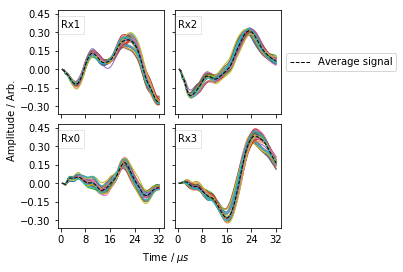

In [7]:
# MAYBE WANT THIS STRAIGHT?
filenames = ['empty'+str(i)+'.csv' for i in range(1,40+1)]
empties = []

for name in filenames:        
    empties.append(radar_reduce(load_radar(path+'data/radar/pre/'+name)))
    
axs = radar_plotter(empties)

# AVERAGE
empty_avg = np.sum(empties,axis=0)/len(empties)
for ch in [1,2,3,4]: # channel 1,2,3, or 4
    ax = axs[plot_pos[ch-1]]
    signal = empty_avg[(ch-1)*64:ch*64]
    ax.plot(np.array(range(1,64+1))*0.5,signal,linewidth=1,linestyle='--',c='black',label='Average signal')

# Put a legend to the right of the rightmost graph
ax = axs[plot_pos[3-1]]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.savefig('empty_cuvettes.png',dpi=300,bbox_inches='tight')
plt.show()

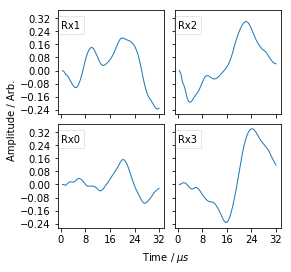

In [11]:
radar_plotter([empties[0]])
plt.savefig('example_radar.png',dpi=300,bbox_inches='tight')

In [8]:
# import dark and process standard
w = np.loadtxt(path+'data/spec/calib/wavelengths.txt')

d = load_spec(path+'/data/spec/calib/dark.txt')
s = load_spec(path+'/data/spec/calib/standard_and_plastic_5ms.txt')
#s = dark_sub(s,d)

# empty cuvette
# emp = load_spec(path+'data/spec/calib/empty_plastic.txt')
# emp = dark_sub(emp,d)

## Import substance data

In [9]:
# #original
# label_ids = {0:'caffeine',1:'maltose',2:'paracetamol',3:'glucose',
#              4:'lactose',5:'bakingSoda',6:'taurine',7:'ibuprofen',
#              8:'aspirin',9:'talcPowder'
#             }

# in order of 'feel'
names = ['caffeine','paracetamol','aspirin','talc','lactose',
         'taurine','bakingSoda','maltose','glucose','ibuprofen']
label_ids = dict()
for i in range(len(names)):
    label_ids[i] = names[i]

runs = 40
data = []
db_path = path+'data/data.db'
   
for label_id in label_ids:
    
    data.append([])
    for n in range(1,runs+1):

        row = read_from_db(db_path,label=label_ids[label_id], run=n)
        # transform all radar frames to get avg of the 3 captured frames
        lab, n, spec, rad = row[0],row[1],row[2],radar_reduce(row[3])
        data[label_id].append([lab,n,spec,rad])
        
targets = list(label_ids.values())
colors = ['b', 'g', 'r', 'c', 'm', 'y','lightblue','lightgreen','orange','grey']

## Plot all spectra

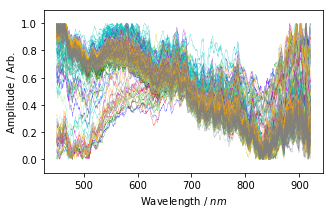

In [97]:
fig = plt.figure(figsize=(5,3))
for j,c,label in zip(label_ids,colors,targets):
    
    frames = [data[j][i][2] for i in range(40)]
    
    for frame in frames:
        
        # raw spectra
#         ax = axs[plot_pos[0]]
#         ax.plot(w,frame,c=c,linewidth=0.2,label=label)
#         ax.plot(w,s,c='black')
        
#         # dark subbed spectra
#         ax = axs[plot_pos[1]]
#         ax.plot(w,dark_sub(frame,d),c=c,linewidth=0.2,label=label)
#         ax.plot(w,dark_sub(s,d),c='black')
        
#         # normalised spectra
#         ax = axs[plot_pos[2]]
#         processed_frame = normalise(dark_sub(frame,d))
#         ax.plot(w,processed_frame,c=c,linewidth=0.2,label=label)
#         ax.plot(w,normalise(s),c='black')

        processed_frame = normalise(boxcar((dark_sub(frame,d)/dark_sub(s,d))[start:end],7))
        plt.plot(w[295:1695],processed_frame,c=c,linewidth=0.2,label=label)
        
plt.ylim(-0.1,1.1)

plt.xlabel("Wavelength / $nm$")
plt.ylabel("Amplitude / Arb.")
plt.savefig('all_calibNorm_spectra.png',dpi=300,bbox_inches='tight')
plt.show()

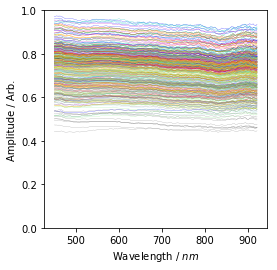

In [38]:
fig = plt.figure(figsize=(4,4))
for j,c,label in zip(label_ids,colors,targets):
    
    frames = [data[j][i][2] for i in range(40)]
    for frame in frames:
        processed_frame = boxcar((dark_sub(frame,d)/dark_sub(s,d))[295:1695],10)
        plt.plot(w[295:1695],processed_frame,c=c,linewidth=0.2,label=label)
        
plt.ylim(0,1)
plt.xlabel("Wavelength / $nm$")
plt.ylabel("Amplitude / Arb.")
#plt.savefig('all_spectra.png')
plt.show()

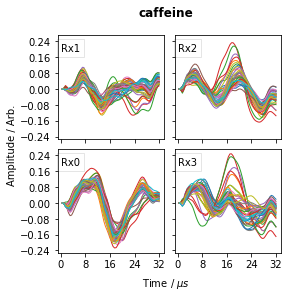

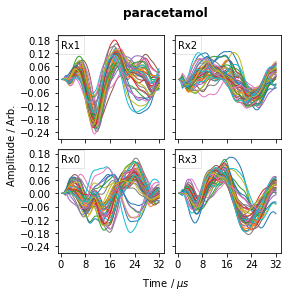

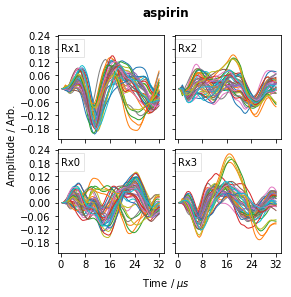

KeyboardInterrupt: 

In [11]:
for j in label_ids:
    rs = [data[j][i][3] for i in range(40)]
    radar_plotter(rs-empty_avg,label_ids[j])
    plt.savefig('radar_'+label_ids[j]+'.png')
    plt.show()

## Average spectra per substance

raw radar

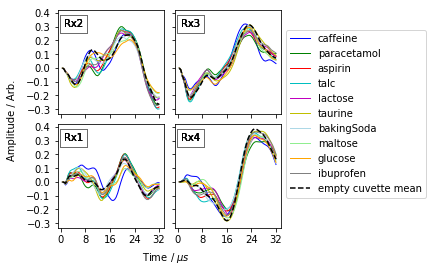

In [14]:
fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
#fig.suptitle('Average raw radar signals',weight='bold')

for j in label_ids:
    rs = [data[j][i][3] for i in range(40)]
    frame = np.sum(rs,axis=0)/40
    
    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        ax = axs[plot_pos[ch-1]]
        signal = frame[(ch-1)*64:ch*64]
        ax.plot(np.array(range(1,64+1))*0.5,signal,c=colors[j],label=label_ids[j],linewidth=1)
        ax.xaxis.set_major_locator(plt.MultipleLocator(8))
        ax.yaxis.set_major_locator(plt.MaxNLocator(8))
        
        ax.text(1,0.3,"Rx"+str(ch),bbox=dict(facecolor='white', alpha=0.1))

# plot empties
for ch in [1,2,3,4]: # channel 1,2,3, or 4
    ax = axs[plot_pos[ch-1]]
    ax.plot(np.array(range(1,64+1))*0.5,empty_avg[(ch-1)*64:ch*64],c='black',linestyle='--',label='empty cuvette mean')

# Put a legend to the right of the rightmost graph
ax = axs[plot_pos[3-1]]
ax.legend(loc='center left', bbox_to_anchor=(1, 0))

fig.text(0.5, 0.01, 'Time / $\mu s$', ha='center')
fig.text(-0.05, 0.5, 'Amplitude / Arb.', va='center', rotation='vertical')

plt.savefig('average_radars.png',dpi=300,bbox_inches='tight')
plt.show()

calibrated radar

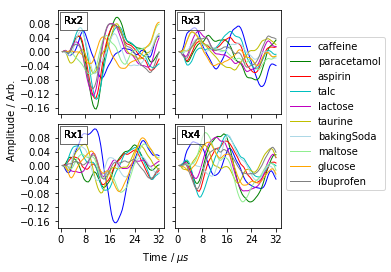

In [15]:
fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
#fig.suptitle('Average raw radar signals',weight='bold')

for j in label_ids:
    rs = [data[j][i][3]-empty_avg for i in range(40)]
    frame = np.sum(rs,axis=0)/40
    
    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        ax = axs[plot_pos[ch-1]]
        signal = frame[(ch-1)*64:ch*64]
        ax.plot(np.array(range(1,64+1))*0.5,signal,c=colors[j],label=label_ids[j],linewidth=1)
        ax.xaxis.set_major_locator(plt.MultipleLocator(8))
        ax.yaxis.set_major_locator(plt.MaxNLocator(8))
        
        ax.text(1,0.08,"Rx"+str(ch),bbox=dict(facecolor='white', alpha=0.1))

# Put a legend to the right of the rightmost graph
ax = axs[plot_pos[3-1]]
ax.legend(loc='center left', bbox_to_anchor=(1, 0))

fig.text(0.5, 0.01, 'Time / $\mu s$', ha='center')
fig.text(-0.05, 0.5, 'Amplitude / Arb.', va='center', rotation='vertical')

plt.savefig('average_calibRadars.png',dpi=300,bbox_inches='tight')
plt.show()

avg calibrated specs

In [10]:
spec_calib_avgs = []
for j in label_ids:
    frames = [boxcar((dark_sub(data[j][i][2],d)/dark_sub(s,d)),10) for i in range(40)]

    avg_frame = np.sum(frames,axis=0)/40
    spec_calib_avgs.append(avg_frame)

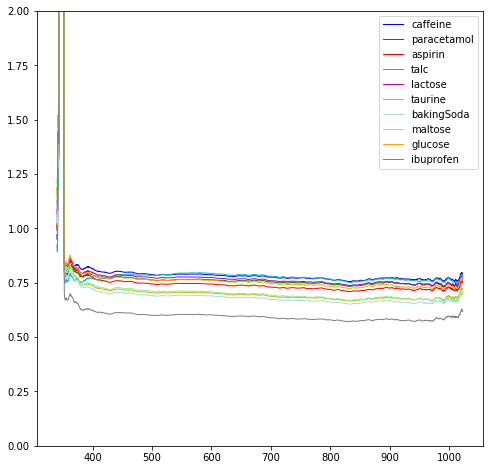

In [27]:
plt.figure(figsize=(8,8))
for i in range(10):
    
    frame = spec_calib_avgs[i]
    c = colors[i]
    label = label_ids[i]
    
    plt.plot(w,frame,linewidth=1,c=c,label=label)

plt.ylim(0,2)
plt.legend()
plt.show()

In [11]:
# for chopping noise:
print(w[295],w[1695])

start = 295
end = 1695

450.3011733113293 920.8314572651853


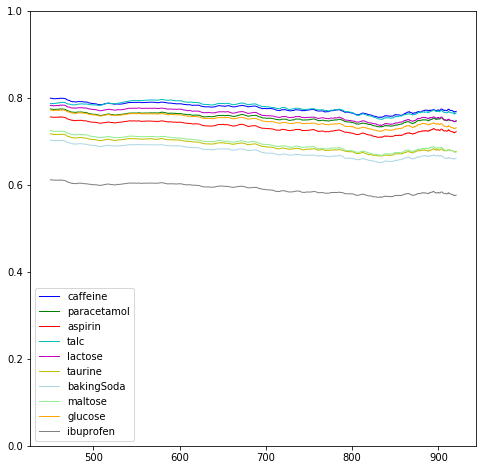

In [18]:
plt.figure(figsize=(8,8))
for i in range(10):
    
    frame = spec_calib_avgs[i]
    c = colors[i]
    label = label_ids[i]
    
    plt.plot(w[start:end],frame[start:end],linewidth=1,c=c,label=label)

plt.ylim(0,1)
plt.legend()
plt.show()

## Prepare data for modelling

In [12]:
# response
y_labels = [data[j][i][0] for j in range(len(data)) for i in range(len(data[j]))]
y = np.array([j for j in range(len(data)) for i in range(len(data[j]))]) # can do this due to the way data was constructed above

Xs = []
datatypes = ['radar','calib_radar','spec','calib_spec','calib_norm_spec','radar + calib_norm_spec','calib_radar + calib_norm_spec']

# 0. radar
Xs.append( np.array([data[j][i][3] for j in range(len(data)) for i in range(len(data[j]))]) )

# 1. calib_radar
Xs.append( np.array([data[j][i][3]-empty_avg for j in range(len(data)) for i in range(len(data[j]))]) )

# 2. spec
Xs.append( np.array([data[j][i][2] for j in range(len(data)) for i in range(len(data[j]))]) )

# 3. calib_spec (BAD)
Xs.append( np.array([boxcar((dark_sub(data[j][i][2],d)/dark_sub(s,d))[start:end],7) for j in range(len(data)) for i in range(len(data[j]))]) )

# 4. calibNorm_spec
Xs.append( np.array([normalise(boxcar((dark_sub(data[j][i][2],d)/dark_sub(s,d))[start:end],7)) for j in range(len(data)) for i in range(len(data[j]))]))

# 5. radar + calibNorm_spec
Xs.append( np.array([np.concatenate([
    data[j][i][3],
    normalise(boxcar((dark_sub(data[j][i][2],d)/dark_sub(s,d))[start:end],7))
]) for j in range(len(data)) for i in range(len(data[j]))]) )

# 6. calib_radar + calibNorm_spec
Xs.append( np.array([np.concatenate([
    data[j][i][3]-empty_avg,
    normalise(boxcar((dark_sub(data[j][i][2],d)/dark_sub(s,d))[start:end],7))
]) for j in range(len(data)) for i in range(len(data[j]))]) )

In [25]:
datatypes = ['radar','calib_radar','spec','calib_spec','calib_norm_spec','radar + calib_norm_spec','calib_radar + calib_norm_spec']

### FFT of radar, per channel

In [13]:
radar_freqs = []
radar_phases = []

for frame in Xs[0]:
    
    fft_freqs = []
    fft_phases = []
    for ch in [1,2,3,4]: # channel 1,2,3, or 4
        
        signal = frame[(ch-1)*64:ch*64]
        channel_fft = np.fft.rfft(signal)
        
        # extract channel frequencies
        channel_freqs = list(np.abs(channel_fft))
        fft_freqs = fft_freqs + channel_freqs
        
        # extract channel phases, chop phases corresponding to insignificant frequencies
        channel_phases = np.where(np.array(channel_freqs)<10**-5,0,np.angle(channel_fft))
        fft_phases = fft_phases + list(channel_phases)

    radar_freqs.append(fft_freqs)
    radar_phases.append(fft_phases)

radar_freqs = np.array(radar_freqs)
radar_phases = np.array(radar_phases)
freqs = np.fft.rfftfreq(64, d=0.5*10**-6)/(10**6)

phases

In [14]:
plot_pos = [(1,0),(0,0),(0,1),(1,1)]

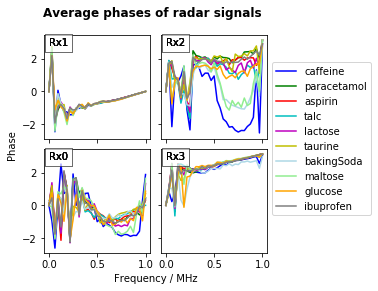

In [14]:
# plot_pos = range(0,4)
# fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
# fig.subplots_adjust(hspace=0, wspace=0.1)

fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Average phases of radar signals',weight='bold')

for j in label_ids:
    rs = [radar_phases[int(j*40+i)] for i in range(40)]
    frame = np.sum(rs,axis=0)/40
    m = len(frame)//4
    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        ax = axs[plot_pos[ch-1]]
        signal = frame[(ch-1)*m:ch*m]
        ax.plot(freqs,signal,c=colors[j],label=label_ids[j])
        ax.text(0,2.8,"Rx"+str(ch-1),bbox=dict(facecolor='white', alpha=0.1)) # make position relative using 'transform'??

# Put a legend to the right of the rightmost graph
ax = axs[plot_pos[3-1]]
ax.legend(loc='center left', bbox_to_anchor=(1, 0))

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Frequency / MHz")
plt.ylabel("Phase")

plt.savefig('average_phases_radars.png',dpi=300,bbox_inches='tight')
plt.show()

frequencies

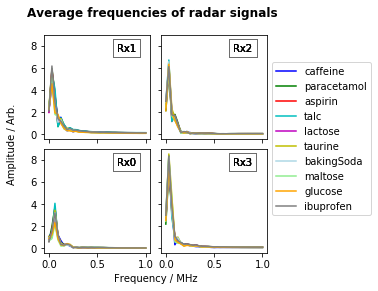

In [ ]:
# plot_pos = range(0,4)
# fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
# fig.subplots_adjust(hspace=0, wspace=0.1)

fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Average frequencies of radar signals',weight='bold')

for j in label_ids:
    rs = [radar_freqs[int(j*40+i)] for i in range(40)]
    frame = np.sum(rs,axis=0)/40
    m = len(frame)//4
    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        ax = axs[plot_pos[ch-1]]
        signal = frame[(ch-1)*m:ch*m]
        ax.plot(freqs,signal,c=colors[j],label=label_ids[j])
        ax.text(0.7,7.5,"Rx"+str(ch-1),bbox=dict(facecolor='white', alpha=0.1)) # make position relative using 'transform'??

# Put a legend to the right of the rightmost graph
ax = axs[plot_pos[3-1]]
ax.legend(loc='center left', bbox_to_anchor=(1, 0))

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Frequency / MHz")
plt.ylabel("Amplitude / Arb.")

plt.savefig('average_freqs_radars.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
for j in label_ids:
    frames = [data[j][i][3] for i in range(40)]
    
    plot_pos = range(0,4)
    fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0, wspace=0)


    fig.suptitle(label_ids[j]+' fourier',weight='bold')

    for ch in [1,2,3,4]: # channel 1,2,3, or 4

        for frame in frames:
            ax = axs[plot_pos[ch-1]]
            signal = frame[(ch-1)*64:ch*64]
            fft_signal = abs(np.fft.rfft(signal))
            ax.plot(fft_signal)
            ax.text(15,7,"Rx"+str(ch),weight='bold') # make position relative using 'transform'??

## Modelling

In [43]:
# FFT - freqs
X = radar_freqs
datatype = 'radar freqs'

In [47]:
# FFT - phases
X = radar_phases
datatype = 'radar phases'

In [39]:
# freqs + phases
X = [list(radar_freqs[i])+list(radar_phases[i]) for i in range(400)]
X = np.array(X)
datatype = 'radar frequencies and phases'

In [70]:
# freqs + phases + calibNorm spec
X = [list(radar_freqs[i])+list(radar_phases[i])+list(Xs[4][i]) for i in range(400)]
X = np.array(X)
datatype = 'radar freqs+phases and calib_norm_spec'

In [64]:
# choose datatype
i = 6
X = Xs[i]
datatype = datatypes[i]

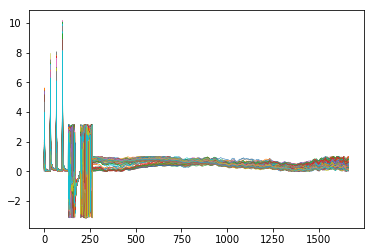

In [71]:
# check input data
for i in range(len(X)):
    plt.plot(X[i],linewidth=0.5)

0.9


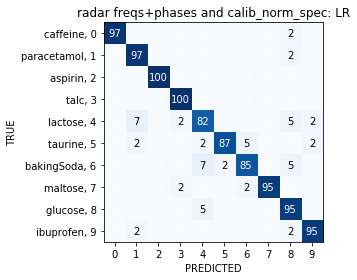

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

0.6625


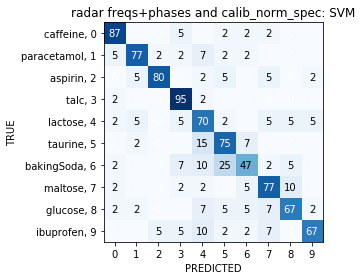

0.8125


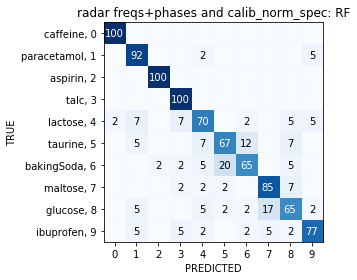

0.9375


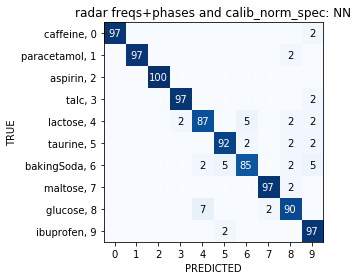

In [72]:
methods = ['LR','SVM','RF','MLPC']
method_names = ['LR','SVM','RF','NN']

accs = []

for method, method_name in zip(methods,method_names):
    
    k = 5
    # do k-fold CV and collect confusion matrices
    confs, acc = kfold_CV(X,y,method,k)

    summed_cm = np.array(confs).sum(axis=0)
    cm = normalise_confusion_matrix(summed_cm)*100
    accs.append(acc)
    print(acc)
    
    plot_confusion_matrix(cm, label_ids, True, title=datatype+': '+method_name)
    plt.savefig(datatype+'_'+method_name+'cm.png',dpi=300,bbox_inches='tight')
    plt.show()

np.savetxt(datatype+'_accuracies.txt',accs)

# PCA

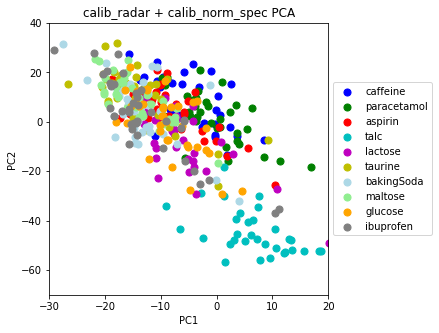

In [67]:
# scale data
X_scaled = StandardScaler().fit_transform(X)

# perform PCA and store results in dataframe
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal component 1', 'Principal component 2'])#, 'Principal component 3'])
targetDf = pd.DataFrame(y_labels)
targetDf.columns =['target']
finalDf = pd.concat([principalDf, targetDf], axis = 1)

# plot results
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal component 1']
               , finalDf.loc[indicesToKeep, 'Principal component 2']
               , c = color
               , s = 50)

ax.set_title(datatype+' PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_ylim(-70,40)
ax.set_xlim(-30,20)

ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5))
#ax.grid()
plt.savefig(datatype+'_PCA.png',dpi=300,bbox_inches='tight')
plt.show()

## Analysis

#### Why does taking the minimum off make predictions worse?


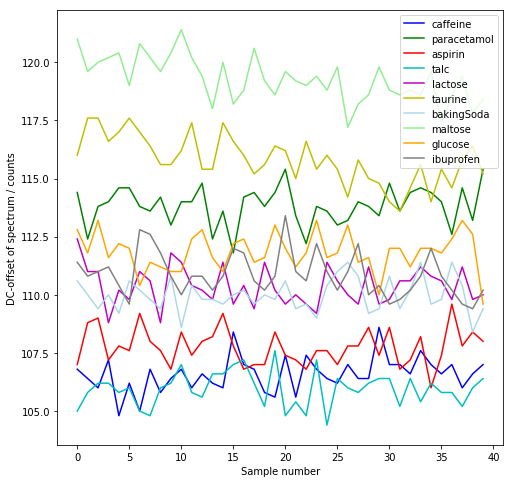

In [61]:
spec_mins = np.array([min(data[j][i][2]) for j in range(len(data)) for i in range(len(data[j]))])

ns = np.array(range(0,len(targets)))*40

plt.figure(figsize=(8,8))
for i,c,label in zip(ns,colors,targets):
    plt.plot(spec_mins[i:i+40],c=c,label=label)

#plt.title('Minima vs sample number')
plt.xlabel('Sample number')
plt.ylabel('DC-offset of spectrum / counts')
plt.legend()
plt.savefig('spec_minima.png',dpi=300,bbox_inches='tight')
plt.show()

We notice that the minimum (e.g. DC-offset) varies with substance type - this must be due to the heating of the lamp/something else to do with the experimental system, and it is this information that leads to the separation on the PC plots and the accuracy of the models. Without this variation, the models struggle.